# 1. Data preparation

(Consider splitting into train/val/test considering the affordances of the objects instead of randomly, so that e.g. pen, telescope and laptop are in the train set and pencil, microscope and desktop computer in the test set.)


(Also, consider adding multiple images of each object. This way, the model can train on mapping object with its affordances multiple times.)

In [1]:
from transformers import VisualBertModel, BertModel, BertTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import random

In [2]:
torch.manual_seed(9)

In [3]:
def clean_up(object_name):
    clean_object_name = ''
    for char in object_name:
        if char == '_':
            clean_object_name += ' '
        elif char == '.':
            break
        else:
            clean_object_name += char
    return clean_object_name

In [4]:
file = '../data/affordance_annotations.txt'
df = pd.read_csv(file)
df.rename(columns = {'Unnamed: 0':'Object'}, inplace = True)
df['Object'] = df['Object'].apply(clean_up)
df.columns = ['Object','ImageNet synset','grasp','lift','throw','push','fix','ride','play','watch','sit on','feed','row','pour from','look through','write with', 'type on']

In [5]:
df

,Object,ImageNet synset,grasp,lift,throw,push,fix,ride,play,watch,sit on,feed,row,pour from,look through,write with,type on
0,automobile engine,n02761557,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,axe,n02764044,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,bicycle,n02834778,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0
3,bottle,n02876657,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0
4,camera,n02942699,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,sickle,n04213353,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
58,spoon,n04284002,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
59,stool,n04326896,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
60,typewriter,n04505036,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1


In [6]:
unique_objects = list(df['Object'])
unique_affordances = [affordance.lower() for affordance in df.columns[2:]]

In [7]:
unique_objects

['automobile engine',
 'axe',
 'bicycle',
 'bottle',
 'camera',
 'can',
 'car tire',
 'carving knife',
 'chair',
 'chalk',
 'cleaver',
 'desktop computer',
 'dish',
 'dog',
 'dustcloth',
 'fishing pole',
 'food turner',
 'frisbee',
 'guitar',
 'hand saw',
 'handset',
 'horse',
 'laptop',
 'microscope',
 'mobile phone',
 'mop',
 'pen',
 'pitcher',
 'power saw',
 'shopping cart',
 'small boat',
 'sofa',
 'teapot',
 'telescope',
 'television',
 'toothbrush',
 'umbrella',
 'vacuum cleaner',
 'violin',
 'wheelbarrow',
 'banjo',
 'bench',
 'bowl',
 'broom',
 'camel',
 'cat',
 'coffee cup',
 'donkey',
 'flagon',
 'hammer',
 'hand truck',
 'kayak',
 'monitor',
 'motorcycle',
 'pencil',
 'rhinoceros',
 'serving cart',
 'sickle',
 'spoon',
 'stool',
 'typewriter',
 'walkie-talkie']

In [8]:
unique_affordances

['grasp',
 'lift',
 'throw',
 'push',
 'fix',
 'ride',
 'play',
 'watch',
 'sit on',
 'feed',
 'row',
 'pour from',
 'look through',
 'write with',
 'type on']

In [9]:
word_to_index = {}
index_to_word = {}
indices = list(range(77))

for i, word in enumerate(unique_objects + unique_affordances):
    word_to_index[word] = i
    index_to_word[i] = word

In [10]:
word_to_index['automobile engine']

0

In [11]:
index_to_word[0]

'automobile engine'

In [12]:
df

,Object,ImageNet synset,grasp,lift,throw,push,fix,ride,play,watch,sit on,feed,row,pour from,look through,write with,type on
0,automobile engine,n02761557,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,axe,n02764044,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,bicycle,n02834778,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0
3,bottle,n02876657,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0
4,camera,n02942699,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,sickle,n04213353,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
58,spoon,n04284002,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
59,stool,n04326896,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
60,typewriter,n04505036,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1


In [13]:
baseline_dict_objects = dict.fromkeys(unique_objects, 0)
for index, row in df.iterrows():
        for i, value in enumerate(row):
            if type(value) == str:
                pass
            else:
                baseline_dict_objects[row[0]] += value
                
baseline_total_objects = 0
for k,v in baseline_dict_objects.items():
    baseline_dict_objects[k] = np.round((v * 100)/15, 2)
    baseline_total_objects += v

baseline_total_objects = np.round((baseline_total_objects/(15*62))*100,2)
print(f'{100-baseline_total_objects} %')

72.26 %


In [14]:
baseline_dict_objects

{'automobile engine': 6.67,
 'axe': 26.67,
 'bicycle': 33.33,
 'bottle': 33.33,
 'camera': 40.0,
 'can': 33.33,
 'car tire': 13.33,
 'carving knife': 26.67,
 'chair': 20.0,
 'chalk': 33.33,
 'cleaver': 26.67,
 'desktop computer': 33.33,
 'dish': 26.67,
 'dog': 20.0,
 'dustcloth': 26.67,
 'fishing pole': 26.67,
 'food turner': 26.67,
 'frisbee': 26.67,
 'guitar': 40.0,
 'hand saw': 26.67,
 'handset': 33.33,
 'horse': 20.0,
 'laptop': 46.67,
 'microscope': 33.33,
 'mobile phone': 33.33,
 'mop': 20.0,
 'pen': 33.33,
 'pitcher': 33.33,
 'power saw': 26.67,
 'shopping cart': 26.67,
 'small boat': 26.67,
 'sofa': 6.67,
 'teapot': 33.33,
 'telescope': 33.33,
 'television': 26.67,
 'toothbrush': 26.67,
 'umbrella': 33.33,
 'vacuum cleaner': 20.0,
 'violin': 40.0,
 'wheelbarrow': 33.33,
 'banjo': 40.0,
 'bench': 20.0,
 'bowl': 26.67,
 'broom': 20.0,
 'camel': 20.0,
 'cat': 20.0,
 'coffee cup': 33.33,
 'donkey': 20.0,
 'flagon': 33.33,
 'hammer': 26.67,
 'hand truck': 33.33,
 'kayak': 26.67,
 'm

In [15]:
baseline_dict_affordances = dict.fromkeys(unique_affordances, 0)

for index, row in df.iterrows():
    for k in baseline_dict_affordances.keys():
        baseline_dict_affordances[k] += row[k]
        
baseline_total_affordances = 0
for k,v in baseline_dict_affordances.items():
    baseline_dict_affordances[k] = np.round((v * 100)/62, 2)
    baseline_total_affordances += v

baseline_total_affordances = np.round((baseline_total_affordances/(15*62))*100,2)
print(f'{baseline_total_objects} %')

27.74 %


In [16]:
baseline_dict_affordances

{'grasp': 59.68,
 'lift': 82.26,
 'throw': 50.0,
 'push': 90.32,
 'fix': 40.32,
 'ride': 19.35,
 'play': 4.84,
 'watch': 6.45,
 'sit on': 25.81,
 'feed': 9.68,
 'row': 3.23,
 'pour from': 9.68,
 'look through': 4.84,
 'write with': 4.84,
 'type on': 4.84}

## 1.1 Pairs of objects and their affordances

In [17]:
df1 = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [18]:
train1 = df1[:42]
val1 = df1[42:52]
test1 = df1[52:]

In [19]:
train1

,Object,ImageNet synset,grasp,lift,throw,push,fix,ride,play,watch,sit on,feed,row,pour from,look through,write with,type on
0,hand truck,n03490119,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0
1,serving cart,n04176068,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0
2,automobile engine,n02761557,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,sickle,n04213353,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
4,can,n02946921,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0
5,flagon,n03355768,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0
6,food turner,n04500060,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
7,dish,n03206908,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
8,mop,n04367480,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
9,stool,n04326896,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0


In [20]:
def get_gold_data_1(table):
    gold_data_pairs = []
    for index, row in table.iterrows():
        for i, value in enumerate(row):
            if type(value) == str:
                pass
            else:
                gold_data_pairs.append((row[0],table.columns[i].lower(),value))
    return gold_data_pairs

In [21]:
train1_pairs = get_gold_data_1(train1)
val1_pairs = get_gold_data_1(val1)
test1_pairs = get_gold_data_1(test1)

In [22]:
train1_pairs

[('hand truck', 'grasp', 0),
 ('hand truck', 'lift', 1),
 ('hand truck', 'throw', 0),
 ('hand truck', 'push', 1),
 ('hand truck', 'fix', 1),
 ('hand truck', 'ride', 1),
 ('hand truck', 'play', 0),
 ('hand truck', 'watch', 0),
 ('hand truck', 'sit on', 1),
 ('hand truck', 'feed', 0),
 ('hand truck', 'row', 0),
 ('hand truck', 'pour from', 0),
 ('hand truck', 'look through', 0),
 ('hand truck', 'write with', 0),
 ('hand truck', 'type on', 0),
 ('serving cart', 'grasp', 0),
 ('serving cart', 'lift', 0),
 ('serving cart', 'throw', 0),
 ('serving cart', 'push', 1),
 ('serving cart', 'fix', 1),
 ('serving cart', 'ride', 1),
 ('serving cart', 'play', 0),
 ('serving cart', 'watch', 0),
 ('serving cart', 'sit on', 1),
 ('serving cart', 'feed', 0),
 ('serving cart', 'row', 0),
 ('serving cart', 'pour from', 0),
 ('serving cart', 'look through', 0),
 ('serving cart', 'write with', 0),
 ('serving cart', 'type on', 0),
 ('automobile engine', 'grasp', 0),
 ('automobile engine', 'lift', 0),
 ('automo

In [23]:
val1_pairs

[('coffee cup', 'grasp', 1),
 ('coffee cup', 'lift', 1),
 ('coffee cup', 'throw', 1),
 ('coffee cup', 'push', 1),
 ('coffee cup', 'fix', 0),
 ('coffee cup', 'ride', 0),
 ('coffee cup', 'play', 0),
 ('coffee cup', 'watch', 0),
 ('coffee cup', 'sit on', 0),
 ('coffee cup', 'feed', 0),
 ('coffee cup', 'row', 0),
 ('coffee cup', 'pour from', 1),
 ('coffee cup', 'look through', 0),
 ('coffee cup', 'write with', 0),
 ('coffee cup', 'type on', 0),
 ('axe', 'grasp', 1),
 ('axe', 'lift', 1),
 ('axe', 'throw', 1),
 ('axe', 'push', 1),
 ('axe', 'fix', 0),
 ('axe', 'ride', 0),
 ('axe', 'play', 0),
 ('axe', 'watch', 0),
 ('axe', 'sit on', 0),
 ('axe', 'feed', 0),
 ('axe', 'row', 0),
 ('axe', 'pour from', 0),
 ('axe', 'look through', 0),
 ('axe', 'write with', 0),
 ('axe', 'type on', 0),
 ('horse', 'grasp', 0),
 ('horse', 'lift', 0),
 ('horse', 'throw', 0),
 ('horse', 'push', 0),
 ('horse', 'fix', 0),
 ('horse', 'ride', 1),
 ('horse', 'play', 0),
 ('horse', 'watch', 0),
 ('horse', 'sit on', 1),
 ('h

In [24]:
test1_pairs

[('laptop', 'grasp', 1),
 ('laptop', 'lift', 1),
 ('laptop', 'throw', 1),
 ('laptop', 'push', 1),
 ('laptop', 'fix', 1),
 ('laptop', 'ride', 0),
 ('laptop', 'play', 0),
 ('laptop', 'watch', 1),
 ('laptop', 'sit on', 0),
 ('laptop', 'feed', 0),
 ('laptop', 'row', 0),
 ('laptop', 'pour from', 0),
 ('laptop', 'look through', 0),
 ('laptop', 'write with', 0),
 ('laptop', 'type on', 1),
 ('guitar', 'grasp', 1),
 ('guitar', 'lift', 1),
 ('guitar', 'throw', 1),
 ('guitar', 'push', 1),
 ('guitar', 'fix', 1),
 ('guitar', 'ride', 0),
 ('guitar', 'play', 1),
 ('guitar', 'watch', 0),
 ('guitar', 'sit on', 0),
 ('guitar', 'feed', 0),
 ('guitar', 'row', 0),
 ('guitar', 'pour from', 0),
 ('guitar', 'look through', 0),
 ('guitar', 'write with', 0),
 ('guitar', 'type on', 0),
 ('walkie-talkie', 'grasp', 1),
 ('walkie-talkie', 'lift', 1),
 ('walkie-talkie', 'throw', 1),
 ('walkie-talkie', 'push', 1),
 ('walkie-talkie', 'fix', 1),
 ('walkie-talkie', 'ride', 0),
 ('walkie-talkie', 'play', 0),
 ('walkie-ta

# 2. Extracting Embeddings

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [26]:
def tokenize_string(text):
    marked_text = "[CLS] " + text + " [SEP]"
    return tokenizer.tokenize(marked_text)

## 2.1 BERT Embeddings

In [27]:
bert_model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [29]:
bert_word_to_embedding = {} # I create this embeddings dictionary so I can easily map words to embeddings

with torch.no_grad():
    
    for subset in [train1_pairs + val1_pairs + test1_pairs]:
    
        for obj, affordance, truth_val in subset:

            if obj not in bert_word_to_embedding.keys():
                tokenized_obj = tokenize_string(obj)
                indexed_obj = tokenizer.convert_tokens_to_ids(tokenized_obj)
                segments_ids = [1] * len(tokenized_obj)
                tokens_tensor = torch.tensor([indexed_obj])
                segments_tensor = torch.tensor([segments_ids])

                outputs = bert_model(tokens_tensor, segments_tensor)
                hidden_states = outputs[2]
                token_vecs = hidden_states[-2][0] # I take the penultimate layer
                obj_embedding = torch.mean(token_vecs, dim=0) # I take the mean over the vectors for each token to get a representation of the whole input

                bert_word_to_embedding[obj] = obj_embedding

            if affordance not in bert_word_to_embedding.keys():
                tokenized_affordance = tokenize_string(affordance)
                indexed_affordance = tokenizer.convert_tokens_to_ids(tokenized_affordance)
                segments_ids = [1] * len(tokenized_affordance)
                tokens_tensor = torch.tensor([indexed_affordance])
                segments_tensor = torch.tensor([segments_ids])

                outputs = bert_model(tokens_tensor, segments_tensor)
                hidden_states = outputs[2]
                token_vecs = hidden_states[-2][0]
                affordance_embedding = torch.mean(token_vecs, dim=0)

                bert_word_to_embedding[affordance] = affordance_embedding


In [30]:
bert_word_to_embedding['coffee cup']

tensor([ 1.1761e-02,  1.6537e-01, -5.8542e-02, -4.0929e-01,  2.7759e-01,
        -2.2142e-01, -4.5131e-01,  5.0575e-01, -4.5594e-01, -3.2246e-01,
         2.8799e-02,  8.9958e-02,  6.7855e-02,  2.2720e-01,  2.7221e-03,
        -7.2005e-02,  4.8871e-02,  5.7241e-01,  5.1877e-01,  6.0364e-02,
        -5.5938e-02, -1.7037e-01, -1.2329e-01, -6.2228e-02,  1.4209e-01,
         7.7891e-02, -2.8361e-01,  8.5463e-02, -5.3574e-02,  2.7535e-01,
         3.9820e-01,  1.2676e-02,  3.7213e-01, -2.3714e-01, -6.3734e-04,
        -5.0599e-01,  3.2774e-01,  4.8251e-01, -4.8535e-01,  1.5368e-01,
        -1.6745e-01, -2.1683e-02,  9.7068e-01, -1.2071e-01,  1.5644e-01,
         2.5727e-01, -7.3714e-01, -2.2904e-01, -7.8507e-01, -3.9459e-01,
         1.8688e-01,  5.4117e-02, -3.6044e-01,  1.0047e-01,  1.5384e-01,
         3.1605e-01,  2.5628e-01, -1.2792e-01,  1.2189e-01,  2.4846e-02,
        -3.4284e-01, -2.0443e-01,  2.6092e-04, -1.7712e-01,  6.2992e-02,
        -6.8667e-02,  5.2262e-01,  1.2636e-01, -4.3

In [31]:
bert_word_to_embedding['grasp'].size()

torch.Size([768])

In [32]:
len(bert_word_to_embedding)

77

In [33]:
bert_embedding_to_word = dict(map(reversed, bert_word_to_embedding.items()))

In [34]:
len(bert_embedding_to_word)

77

In [35]:
bert_embedding_to_word[bert_word_to_embedding['coffee cup']]

'coffee cup'

## 2.2 VisualBERT Embeddings

In [36]:
visual_bert_model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre",output_hidden_states=True)

Some weights of the model checkpoint at uclanlp/visualbert-vqa-coco-pre were not used when initializing VisualBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing VisualBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VisualBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
visual_bert_word_to_embedding = {} # I create this embeddings dictionary so I can easily map words to embeddings

with torch.no_grad():
    
    for subset in [train1_pairs + val1_pairs + test1_pairs]:
    
        for obj, affordance, truth_val in subset:

            if obj not in visual_bert_word_to_embedding.keys():
                tokenized_obj = tokenize_string(obj)
                indexed_obj = tokenizer.convert_tokens_to_ids(tokenized_obj)
                segments_ids = [1] * len(tokenized_obj)
                tokens_tensor = torch.tensor([indexed_obj])
                segments_tensor = torch.tensor([segments_ids])

                outputs = visual_bert_model(tokens_tensor, segments_tensor)
                hidden_states = outputs[2]
                token_vecs = hidden_states[-2][0] # I take the penultimate layer
                obj_embedding = torch.mean(token_vecs, dim=0) # I take the mean over the vectors for each token to get a representation of the whole input

                visual_bert_word_to_embedding[obj] = obj_embedding

            if affordance not in visual_bert_word_to_embedding.keys():
                tokenized_affordance = tokenize_string(affordance)
                indexed_affordance = tokenizer.convert_tokens_to_ids(tokenized_affordance)
                segments_ids = [1] * len(tokenized_affordance)
                tokens_tensor = torch.tensor([indexed_affordance])
                segments_tensor = torch.tensor([segments_ids])

                outputs = visual_bert_model(tokens_tensor, segments_tensor)
                hidden_states = outputs[2]
                token_vecs = hidden_states[-2][0]
                affordance_embedding = torch.mean(token_vecs, dim=0)

                visual_bert_word_to_embedding[affordance] = affordance_embedding

In [38]:
visual_bert_word_to_embedding['coffee cup']

tensor([-1.1488e-01,  2.8898e-01,  3.3471e-01, -2.6124e-01,  9.6840e-02,
        -2.2301e-01,  1.4204e-01, -9.8500e-02, -2.9749e-01, -3.4153e-01,
        -1.5345e-01,  8.5641e-03, -2.0052e-01,  2.6325e-01,  9.6829e-02,
         1.4308e-01,  3.0279e-02,  8.8183e-02,  3.7079e-01, -4.2185e-01,
        -2.2610e-01, -2.7353e-02, -1.6980e-01,  4.9023e-02, -1.0711e-01,
        -2.2149e-01, -1.0475e-01, -1.4782e-01,  1.3282e-01, -1.5429e-01,
         3.5487e-01, -8.5045e-02,  3.0713e-01,  3.0895e-03,  2.9201e-01,
        -1.2735e-01,  1.7551e-01,  8.1742e-02, -1.2363e-01,  4.9050e-02,
        -2.6848e-01,  1.2090e-01,  3.1243e-01,  3.7343e-01,  1.5022e-01,
         5.1614e-03, -3.3208e-01,  6.6584e-02, -4.4918e-01, -5.1149e-01,
         2.9058e-01,  5.0829e-02,  1.3263e-01, -2.6644e-01, -5.6575e-02,
         2.1564e-01,  2.3412e-01,  1.9256e-01,  3.5003e-01,  1.3355e-02,
         2.8871e-02, -8.3321e-02,  7.0730e-02, -2.0450e-01, -2.7815e-01,
        -4.3389e-02,  3.5929e-01, -2.8819e-01, -3.3

In [39]:
len(visual_bert_word_to_embedding)

77

In [40]:
visual_bert_embedding_to_word = dict(map(reversed, visual_bert_word_to_embedding.items()))

In [41]:
len(visual_bert_embedding_to_word)

77

In [42]:
visual_bert_embedding_to_word[visual_bert_word_to_embedding['coffee cup']]

'coffee cup'

# 3. The probe model

In [43]:
bert_hyperparameters = {
    "model":"bert_probe",
    "epochs":2000,
    "batch_size":64,
    "learning_rate":0.005}

In [44]:
visual_bert_hyperparameters = {
    "model":"visual_bert_probe",
    "epochs":2000,
    "batch_size":64,
    "learning_rate":0.005}

In [45]:
class Probe(nn.Module):
    def __init__(self):
        super(Probe, self).__init__()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(768, 2)
        self.softmax = nn.LogSoftmax(1)
        
    def forward(self, obj, affordance):
        combined_vector = obj * affordance
        x1 = self.sigmoid(combined_vector)
        x2 = self.fc1(x1)
        output = self.softmax(x2)
        return output

# 4. Training

In [46]:
train_data = [(bert_word_to_embedding[x], bert_word_to_embedding[y], visual_bert_word_to_embedding[x], visual_bert_word_to_embedding[y], z, word_to_index[x], word_to_index[y]) for x,y,z in train1_pairs]
val_data = [(bert_word_to_embedding[x], bert_word_to_embedding[y], visual_bert_word_to_embedding[x], visual_bert_word_to_embedding[y], z, word_to_index[x], word_to_index[y]) for x,y,z in val1_pairs]
test_data = [(bert_word_to_embedding[x], bert_word_to_embedding[y], visual_bert_word_to_embedding[x], visual_bert_word_to_embedding[y],z, word_to_index[x], word_to_index[y]) for x,y,z in test1_pairs]

train_dataloader = DataLoader(train_data, batch_size=bert_hyperparameters["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=bert_hyperparameters["batch_size"], shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=bert_hyperparameters["batch_size"], shuffle=True)

In [47]:
# The structure in each bach is: 
# bert object embedding, 
# bert affordance embedding, 
# visualbert object embedding, 
# visualbert affordance embedding, 
# truth values,
# object id
# affordance id

In [48]:
next(iter(train_dataloader))

[tensor([[-0.0331, -0.2306, -0.4502,  ..., -0.1308, -0.0917, -0.5073],
         [ 0.1491,  0.1467, -0.0690,  ..., -0.1286, -0.3454, -0.5936],
         [-0.3887, -0.0957, -0.3382,  ..., -0.2841,  0.0785,  0.0709],
         ...,
         [-0.2745,  0.2688, -0.0703,  ..., -0.3979, -0.1280,  0.0526],
         [-0.2506, -0.2260, -0.3923,  ...,  0.3034, -0.2864, -0.3805],
         [-0.2745,  0.2688, -0.0703,  ..., -0.3979, -0.1280,  0.0526]]),
 tensor([[-0.1563, -0.2893, -0.2606,  ..., -0.5954, -0.3939,  0.4428],
         [ 0.2617, -0.0452,  0.0300,  ..., -0.3789, -0.5106, -0.0081],
         [-0.4622,  0.0035, -0.2192,  ..., -0.4366, -0.5006,  0.3134],
         ...,
         [ 0.3064,  0.1747,  0.0743,  ..., -0.0878, -0.4967, -0.0787],
         [-0.0295,  0.1914, -0.0542,  ..., -0.2621, -0.6060, -0.0255],
         [ 0.0026,  0.1029, -0.2838,  ..., -0.3871, -0.4444, -0.1516]]),
 tensor([[ 0.5531,  0.3185,  0.3861,  ...,  0.1290, -0.1469, -0.5343],
         [ 0.0558,  0.2820,  0.2257,  ..., -0

## 4.1 Training the BERT Probe

In [49]:
#device = "cuda:3" if torch.cuda.is_available() else "cpu"
device = "cpu"

In [50]:
def plot_accuracy(epochs, train_acc, val_acc):
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(epochs, train_acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.legend()
    plt.show()
    return

In [51]:
def plot_loss(epochs, train_loss, val_loss):
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(epochs, train_loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.legend()
    plt.show()
    return

Probe(
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=768, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)
1
0
3
0.701231062412262
6
0.7211174170176188
8
0.7263257503509521
11
0.7263257503509521
12
0.7263257503509521
16
0.736268937587738
20
0.736268937587738
35
0.7613636453946432
59
0.7670454581578573
98
0.7821969787279764
133
0.7874053120613098
144
0.8087121248245239
214
0.8290719787279764
234
0.8290719787279764
246
0.8295454581578573
284
0.8390151460965475
303
0.8394886453946432
318
0.8446969787279764
398
0.8546401460965475
407
0.8598484794298807
452
0.8598484794298807
604
0.8598484794298807
891
0.875
1087
0.875
1177
0.8754734794298807
1207
0.8754734794298807
1269
0.8858901460965475
1516
0.8858901460965475
1637
0.8858901460965475
1665
0.8858901460965475
1718
0.8858901460965475
1736
0.8858901460965475
1767
0.8858901460965475
1879
0.890625
1992
0.8910984794298807


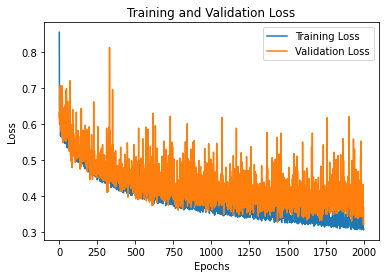

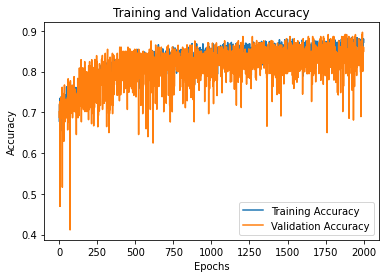

In [52]:
bert_probe = Probe()
print(bert_probe)
torch.nn.init.uniform_(bert_probe.fc1.weight, a=0, b=1)
bert_probe.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(
    bert_probe.parameters(),
    lr=bert_hyperparameters["learning_rate"]
)

epoch_list = []
val_loss_list = []
train_loss_list = []
total_loss = 0

train_accuracy_list = []
val_accuracy_list = []

for epoch in range(bert_hyperparameters["epochs"]):
    
    # TRAIN LOOP
    training_loss = 0
    bert_probe.train()
    
    epoch_accuracy = 0
    
    for i, batch in enumerate(train_dataloader):
        
        obj = batch[0]
        affordance = batch[1]
        truth_value = batch[4]
        
        output = bert_probe(obj, affordance)
        bert_loss = criterion(output,truth_value)
        
        bert_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += bert_loss.item()
        training_loss += bert_loss.item()
        
        # calculate training accuracy
        prediction = torch.argmax(output, dim=1)
        correct_predictions = torch.eq(prediction,truth_value).long()
        batch_accuracy = float(sum(correct_predictions)/len(correct_predictions))
        epoch_accuracy += batch_accuracy
    
    # VALIDATION LOOP
    validation_loss = 0
    bert_probe.eval()
    
    val_epoch_accuracy = 0
    
    for i, batch in enumerate(val_dataloader):
        
        obj = batch[0]
        affordance = batch[1]
        truth_value = batch[4]
        
        output = bert_probe(obj, affordance)
        bert_loss = criterion(output,truth_value)
        validation_loss += bert_loss.item()
        
        # calculate validation accuracy
        prediction = torch.argmax(output, dim=1)
        correct_predictions = torch.eq(prediction,truth_value).long()
        batch_accuracy = float(sum(correct_predictions)/len(correct_predictions))
        val_epoch_accuracy += batch_accuracy
    
    epoch_list.append(epoch+1)
    training_loss_avg = training_loss/len(train_dataloader)
    train_loss_list.append(training_loss_avg)
    validation_loss_avg = validation_loss/len(val_dataloader)
    val_loss_list.append(validation_loss_avg)
    
    best_accuracy = best_accuracy = max(val_accuracy_list) if val_accuracy_list else 0
    if (val_epoch_accuracy/len(val_dataloader)) >= best_accuracy:
        print(epoch+1)
        print(best_accuracy)
        torch.save(bert_probe.state_dict(), "|".join([f"{k}_{v}" for k, v in bert_hyperparameters.items()]))
    
    train_accuracy_list.append(epoch_accuracy/len(train_dataloader))
    val_accuracy_list.append(val_epoch_accuracy/len(val_dataloader))

    #print("Epoch: {}".format(epoch+1))
    #print("Training loss: {}".format(training_loss_avg))
    #print("Validation loss: {}".format(validation_loss_avg))
    #print("Training accuracy: {}".format(epoch_accuracy/len(train_dataloader)))
    #print("Validation accuracy: {}".format(val_epoch_accuracy/len(val_dataloader)))
    
plot_loss(epoch_list, train_loss_list, val_loss_list)
plot_accuracy(epoch_list, train_accuracy_list, val_accuracy_list)

## 4.2 Training the VisualBERT Probe

Probe(
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=768, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)
1
0
23
0.7462121248245239
172
0.7561553120613098
208
0.7732007503509521
229
0.7788825829823812
232
0.7836174170176188
301
0.8134469787279764
342
0.8233901460965475
400
0.8238636453946432
464
0.8290719787279764
583
0.8342803120613098
732
0.8446969787279764
809
0.8541666666666666
1109
0.859375
1539
0.8598484794298807
1895
0.8650568127632141


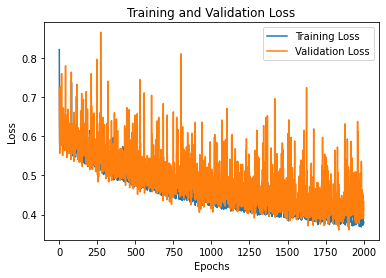

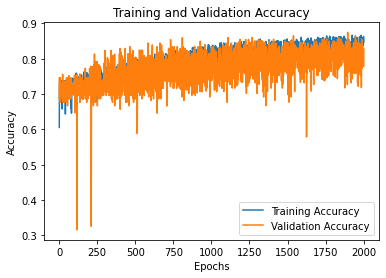

In [53]:
visual_bert_probe = Probe()
print(visual_bert_probe)
torch.nn.init.uniform_(visual_bert_probe.fc1.weight, a=0, b=1)
visual_bert_probe.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(
    visual_bert_probe.parameters(),
    lr=visual_bert_hyperparameters["learning_rate"]
)

epoch_list = []
val_loss_list = []
train_loss_list = []
total_loss = 0

train_accuracy_list = []
val_accuracy_list = []

for epoch in range(visual_bert_hyperparameters["epochs"]):
    
    # TRAIN LOOP
    training_loss = 0
    visual_bert_probe.train()
    
    epoch_accuracy = 0
    
    for i, batch in enumerate(train_dataloader):
        
        obj = batch[2]
        affordance = batch[3]
        truth_value = batch[4]
        
        output = visual_bert_probe(obj, affordance)
        visual_bert_loss = criterion(output,truth_value)
        
        visual_bert_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += visual_bert_loss.item()
        training_loss += visual_bert_loss.item()
        
        # calculate training accuracy
        prediction = torch.argmax(output, dim=1)
        correct_predictions = torch.eq(prediction,truth_value).long()
        batch_accuracy = float(sum(correct_predictions)/len(correct_predictions))
        epoch_accuracy += batch_accuracy
    
    # VALIDATION LOOP
    validation_loss = 0
    visual_bert_probe.eval()
    
    val_epoch_accuracy = 0
    
    for i, batch in enumerate(val_dataloader):
        
        
        obj = batch[2]
        affordance = batch[3]
        truth_value = batch[4]
        
        output = visual_bert_probe(obj, affordance)
        visual_bert_loss = criterion(output,truth_value)
        validation_loss += visual_bert_loss.item()
        
        # calculate validation accuracy
        prediction = torch.argmax(output, dim=1)
        correct_predictions = torch.eq(prediction,truth_value).long()
        batch_accuracy = float(sum(correct_predictions)/len(correct_predictions))
        val_epoch_accuracy += batch_accuracy
    
    epoch_list.append(epoch+1)
    training_loss_avg = training_loss/len(train_dataloader)
    train_loss_list.append(training_loss_avg)
    validation_loss_avg = validation_loss/len(val_dataloader)
    val_loss_list.append(validation_loss_avg)
    
    best_accuracy = max(val_accuracy_list) if val_accuracy_list else 0
    if (val_epoch_accuracy/len(val_dataloader)) > best_accuracy:
        print(epoch+1)
        print(best_accuracy)
        torch.save(visual_bert_probe.state_dict(), "|".join([f"{k}_{v}" for k, v in visual_bert_hyperparameters.items()]))
    
    train_accuracy_list.append(epoch_accuracy/len(train_dataloader))
    val_accuracy_list.append(val_epoch_accuracy/len(val_dataloader))

    #print("Epoch: {}".format(epoch+1))
    #print("Training loss: {}".format(training_loss_avg))
    #print("Validation loss: {}".format(validation_loss_avg))
    #print("Training accuracy: {}".format(epoch_accuracy/len(train_dataloader)))
    #print("Validation accuracy: {}".format(val_epoch_accuracy/len(val_dataloader)))
    
plot_loss(epoch_list, train_loss_list, val_loss_list)
plot_accuracy(epoch_list, train_accuracy_list, val_accuracy_list)

# 5. Testing

## 5.1.1 Testing the BERT Probe on test data

In [54]:
bert_probe = Probe()
bert_probe.load_state_dict(torch.load("model_bert_probe|epochs_2000|batch_size_64|learning_rate_0.005"))

<All keys matched successfully>

In [55]:
bert_probe = bert_probe.to(device)
criterion = nn.NLLLoss()
test_loss = 0
bert_probe.eval()

total = 0
correct = 0

per_word_total = dict.fromkeys(bert_word_to_embedding, 0)
per_word_correct = dict.fromkeys(bert_word_to_embedding, 0)

tp_bert = 0
fp_bert = 0
tn_bert = 0
fn_bert = 0


for i, batch in enumerate(test_dataloader):
    
    obj = batch[0]
    affordance = batch[1]
    target = batch[4]

    with torch.no_grad(): 
        
        output = bert_probe(obj, affordance)
        
        bert_loss = criterion(output, target)
        test_loss += bert_loss.item()

        # Calculate total accuracy
        total += len(batch[0])
        
        prediction = torch.argmax(output, dim=1)
        correct_predictions = torch.eq(prediction,target).long()
        correct += float(sum(correct_predictions))

        # Calculate per-object and per-affordance accuracy
        object_indices = batch[5].tolist()
        objects = [index_to_word[i] for i in object_indices]
        affordance_indices = batch[6].tolist()
        affordances = [index_to_word[i] for i in affordance_indices]
        
        for n,word in enumerate(objects):
            if prediction[n] == target[n]:
                per_word_correct[word] += 1
            per_word_total[word] += 1
            
        for n,word in enumerate(affordances):
            if prediction[n] == target[n]:
                per_word_correct[word] += 1
            per_word_total[word] += 1
            
        # Calculate tp,fp,tn,fn
        for i, value in enumerate(prediction.tolist()):
            if target.tolist()[i] == 1 and prediction.tolist()[i] == 1:
                tp_bert += 1
            elif target.tolist()[i] == 0 and prediction.tolist()[i] == 1:
                fp_bert += 1
            elif target.tolist()[i] == 1 and prediction.tolist()[i] == 0:
                fn_bert += 1
            elif target.tolist()[i] == 0 and prediction.tolist()[i] == 0:
                tn_bert += 1
        

        print('>', np.round(test_loss/(i+1), 4), end='\r')

accuracy_bert_probe = correct / total
per_object_accuracy_bert_probe = {word : (per_word_correct[word] / per_word_total[word]) for word in unique_objects if per_word_total[word] > 0}
per_affordance_accuracy_bert_probe = {word : (per_word_correct[word] / per_word_total[word]) for word in unique_affordances if per_word_total[word] > 0}

print(f'Total accuracy BERT probe: {np.round(accuracy_bert_probe * 100, 2)} %')
print()

print('Per-object accuracy BERT probe:')
for k,v in per_object_accuracy_bert_probe.items():
    print(f'{k} : {np.round(v * 100, 2)} %')
print()
    
print('Per-affordance accuracy BERT probe:')
for k,v in per_affordance_accuracy_bert_probe.items():
    print(f'{k} : {np.round(v * 100, 2)} %')

Total accuracy BERT probe: 83.33 %

Per-object accuracy BERT probe:
carving knife : 86.67 %
dustcloth : 80.0 %
guitar : 80.0 %
handset : 100.0 %
laptop : 80.0 %
power saw : 86.67 %
violin : 80.0 %
bowl : 100.0 %
kayak : 53.33 %
walkie-talkie : 86.67 %

Per-affordance accuracy BERT probe:
grasp : 80.0 %
lift : 90.0 %
throw : 60.0 %
push : 100.0 %
fix : 60.0 %
ride : 70.0 %
play : 80.0 %
watch : 50.0 %
sit on : 80.0 %
feed : 100.0 %
row : 90.0 %
pour from : 100.0 %
look through : 100.0 %
write with : 100.0 %
type on : 90.0 %


In [56]:
accuracy_bert = (tp_bert + tn_bert) / (tp_bert + fp_bert + tn_bert + fn_bert)
print(f'{np.round(accuracy_bert * 100, 2)}%')

83.33%


In [57]:
precision_bert = tp_bert / (tp_bert + fp_bert)
print(f'{np.round(precision_bert * 100, 2)}%')

72.22%


In [58]:
recall_bert = tp_bert / (tp_bert + fn_bert)
print(f'{np.round(recall_bert * 100, 2)}%')

79.59%


In [59]:
f1_bert = (2 * recall_bert * precision_bert) / (recall_bert + precision_bert)
print(f'{np.round(f1_bert * 100, 2)}%')

75.73%


## 5.1.2 Testing the BERT Probe on seen objects

In [60]:
bert_word_to_embedding['sickle']

tensor([-5.5894e-01, -3.0844e-01, -3.2103e-01, -4.1999e-02, -3.1797e-01,
         4.7128e-02, -2.1603e-01,  1.6020e-01, -6.7184e-01, -3.4304e-01,
         1.9071e-01,  1.5088e-01,  2.3365e-01,  2.3858e-01, -4.5530e-01,
         1.1135e-01, -3.9129e-01,  1.8546e-03, -3.2472e-01, -3.8566e-02,
         2.5727e-01,  5.4242e-01, -5.0092e-01,  1.8427e-01, -1.2627e-01,
        -3.5932e-02, -3.5895e-01,  1.2906e-01, -8.9018e-02,  2.7084e-01,
        -1.5569e-01,  1.3382e-01,  1.5780e-01, -3.4467e-01,  4.6099e-02,
        -3.4208e-01, -1.0777e-01,  3.3013e-01, -1.5942e-01,  1.4975e-01,
        -1.8282e-01, -1.0758e-01,  6.1299e-01, -1.1144e-01,  4.6459e-01,
        -3.6743e-01, -8.5432e-01,  4.1498e-01,  2.0724e-02, -1.0234e-01,
        -2.0037e-01, -4.5104e-01, -6.7184e-01, -1.8522e-03,  5.4259e-02,
         2.5832e-01,  2.9730e-01, -3.6633e-02,  2.8898e-02, -2.6731e-01,
        -3.9977e-01, -3.7927e-01,  1.5937e-02, -2.3859e-01, -1.4087e-01,
         3.2333e-01,  2.1938e-01,  2.2658e-01, -6.7

In [61]:
with torch.no_grad():
    for affordance in unique_affordances:
        output = bert_probe(bert_word_to_embedding['sickle'].unsqueeze(0), bert_word_to_embedding[affordance].unsqueeze(0))
        print('sickle, carving knife')
        print(f'{affordance}: {torch.argmax(output)}')
        output = bert_probe(bert_word_to_embedding['carving knife'].unsqueeze(0), bert_word_to_embedding[affordance].unsqueeze(0))
        print(f'{affordance}: {torch.argmax(output)}')
        print()
    
    for affordance in unique_affordances:
        output = bert_probe(bert_word_to_embedding['banjo'].unsqueeze(0), bert_word_to_embedding[affordance].unsqueeze(0))
        print('banjo, guitar')
        print(f'{affordance}: {torch.argmax(output)}')
        output = bert_probe(bert_word_to_embedding['guitar'].unsqueeze(0), bert_word_to_embedding[affordance].unsqueeze(0))
        print(f'{affordance}: {torch.argmax(output)}')
        print()
        
    for affordance in unique_affordances:
        output = bert_probe(bert_word_to_embedding['small boat'].unsqueeze(0), bert_word_to_embedding[affordance].unsqueeze(0))
        print('small boat, kayak')
        print(f'{affordance}: {torch.argmax(output)}')
        output = bert_probe(bert_word_to_embedding['kayak'].unsqueeze(0), bert_word_to_embedding[affordance].unsqueeze(0))
        print(f'{affordance}: {torch.argmax(output)}')
        print()

sickle, carving knife
grasp: 1
grasp: 1

sickle, carving knife
lift: 1
lift: 1

sickle, carving knife
throw: 1
throw: 0

sickle, carving knife
push: 1
push: 1

sickle, carving knife
fix: 0
fix: 1

sickle, carving knife
ride: 0
ride: 0

sickle, carving knife
play: 0
play: 0

sickle, carving knife
watch: 0
watch: 0

sickle, carving knife
sit on: 0
sit on: 0

sickle, carving knife
feed: 0
feed: 0

sickle, carving knife
row: 0
row: 0

sickle, carving knife
pour from: 0
pour from: 0

sickle, carving knife
look through: 0
look through: 0

sickle, carving knife
write with: 0
write with: 0

sickle, carving knife
type on: 0
type on: 0

banjo, guitar
grasp: 1
grasp: 1

banjo, guitar
lift: 1
lift: 1

banjo, guitar
throw: 1
throw: 1

banjo, guitar
push: 1
push: 1

banjo, guitar
fix: 1
fix: 1

banjo, guitar
ride: 0
ride: 1

banjo, guitar
play: 0
play: 0

banjo, guitar
watch: 0
watch: 1

banjo, guitar
sit on: 0
sit on: 0

banjo, guitar
feed: 0
feed: 0

banjo, guitar
row: 0
row: 0

banjo, guitar
pour

## 5.2.1 Testing the VisualBERT Probe on test data

In [62]:
visual_bert_probe = Probe()
visual_bert_probe.load_state_dict(torch.load("model_visual_bert_probe|epochs_2000|batch_size_64|learning_rate_0.005"))

<All keys matched successfully>

In [63]:
visual_bert_probe = visual_bert_probe.to(device)
test_loss = 0
criterion = nn.NLLLoss()
visual_bert_probe.eval()

total = 0
correct = 0

per_word_total = dict.fromkeys(visual_bert_word_to_embedding, 0)
per_word_correct = dict.fromkeys(visual_bert_word_to_embedding, 0)

tp_visual_bert = 0
fp_visual_bert = 0
tn_visual_bert = 0
fn_visual_bert = 0

for i, batch in enumerate(test_dataloader):
    
    obj = batch[2]
    affordance = batch[3]
    target = batch[4]

    with torch.no_grad(): 
        
        output = visual_bert_probe(obj, affordance)
        
        visual_bert_loss = criterion(output, target)
        test_loss += visual_bert_loss.item()

        # Calculate total accuracy
        total += len(batch[0])
        
        prediction = torch.argmax(output, dim=1)
        correct_predictions = torch.eq(prediction,target).long()
        correct += float(sum(correct_predictions))

        # Calculate per word accuracy
        object_indices = batch[5].tolist()
        objects = [index_to_word[i] for i in object_indices]
        affordance_indices = batch[6].tolist()
        affordances = [index_to_word[i] for i in affordance_indices]
        
        for n,word in enumerate(objects):
            if prediction[n] == target[n]:
                per_word_correct[word] += 1
            per_word_total[word] += 1
            
        for n,word in enumerate(affordances):
            if prediction[n] == target[n]:
                per_word_correct[word] += 1
            per_word_total[word] += 1
            
        # Calculate tp,fp,tn,fn
        for i, value in enumerate(prediction.tolist()):
            if target.tolist()[i] == 1 and prediction.tolist()[i] == 1:
                tp_visual_bert += 1
            elif target.tolist()[i] == 0 and prediction.tolist()[i] == 1:
                fp_visual_bert += 1
            elif target.tolist()[i] == 1 and prediction.tolist()[i] == 0:
                fn_visual_bert += 1
            elif target.tolist()[i] == 0 and prediction.tolist()[i] == 0:
                tn_visual_bert += 1

        print('>', np.round(test_loss/(i+1), 4), end='\r')

accuracy_visual_bert_probe = correct / total
per_object_accuracy_visual_bert_probe = {word : (per_word_correct[word] / per_word_total[word]) for word in unique_objects if per_word_total[word] > 0}
per_affordance_accuracy_visual_bert_probe = {word : (per_word_correct[word] / per_word_total[word]) for word in unique_affordances if per_word_total[word] > 0}

print(f'Total accuracy VisualBERT probe: {np.round(accuracy_visual_bert_probe * 100, 2)} %')
print()

print('Per-object accuracy VisualBERT probe:')
for k,v in per_object_accuracy_visual_bert_probe.items():
    print(f'{k} : {np.round(v * 100, 2)} %')
print()

print('Per-affordance accuracy VisualBERT probe:')
for k,v in per_affordance_accuracy_visual_bert_probe.items():
    print(f'{k} : {np.round(v * 100, 2)} %')


Total accuracy VisualBERT probe: 83.33 %

Per-object accuracy VisualBERT probe:
carving knife : 86.67 %
dustcloth : 93.33 %
guitar : 73.33 %
handset : 86.67 %
laptop : 80.0 %
power saw : 93.33 %
violin : 80.0 %
bowl : 93.33 %
kayak : 73.33 %
walkie-talkie : 73.33 %

Per-affordance accuracy VisualBERT probe:
grasp : 80.0 %
lift : 80.0 %
throw : 10.0 %
push : 100.0 %
fix : 50.0 %
ride : 90.0 %
play : 80.0 %
watch : 90.0 %
sit on : 90.0 %
feed : 100.0 %
row : 90.0 %
pour from : 100.0 %
look through : 100.0 %
write with : 100.0 %
type on : 90.0 %


In [64]:
accuracy_visual_bert = (tp_visual_bert + tn_visual_bert) / (tp_visual_bert + fp_visual_bert + tn_visual_bert + fn_visual_bert)
print(f'{np.round(accuracy_visual_bert * 100, 2)}%')

83.33%


In [65]:
precision_visual_bert = tp_visual_bert / (tp_visual_bert + fp_visual_bert)
print(f'{np.round(precision_visual_bert * 100, 2)}%')

90.0%


In [66]:
recall_visual_bert = tp_visual_bert / (tp_visual_bert + fn_visual_bert)
print(f'{np.round(recall_visual_bert * 100, 2)}%')

55.1%


In [67]:
f1_visual_bert = (2 * recall_visual_bert * precision_visual_bert) / (recall_visual_bert + precision_visual_bert)
print(f'{np.round(f1_visual_bert * 100, 2)}%')

68.35%


## 5.2.2 Testing the VisualBERT Probe on seen data

In [68]:
with torch.no_grad():
    for affordance in unique_affordances:
        output = visual_bert_probe(visual_bert_word_to_embedding['sickle'].unsqueeze(0), visual_bert_word_to_embedding[affordance].unsqueeze(0))
        print('sickle, carving knife')
        print(f'{affordance}: {torch.argmax(output)}')
        output = visual_bert_probe(visual_bert_word_to_embedding['carving knife'].unsqueeze(0), visual_bert_word_to_embedding[affordance].unsqueeze(0))
        print(f'{affordance}: {torch.argmax(output)}')
        print()
    
    for affordance in unique_affordances:
        output = visual_bert_probe(visual_bert_word_to_embedding['banjo'].unsqueeze(0), visual_bert_word_to_embedding[affordance].unsqueeze(0))
        print('banjo, guitar')
        print(f'{affordance}: {torch.argmax(output)}')
        output = visual_bert_probe(visual_bert_word_to_embedding['guitar'].unsqueeze(0), visual_bert_word_to_embedding[affordance].unsqueeze(0))
        print(f'{affordance}: {torch.argmax(output)}')
        print()
        
    for affordance in unique_affordances:
        output = visual_bert_probe(visual_bert_word_to_embedding['small boat'].unsqueeze(0), visual_bert_word_to_embedding[affordance].unsqueeze(0))
        print('small boat, kayak')
        print(f'{affordance}: {torch.argmax(output)}')
        output = visual_bert_probe(visual_bert_word_to_embedding['kayak'].unsqueeze(0), visual_bert_word_to_embedding[affordance].unsqueeze(0))
        print(f'{affordance}: {torch.argmax(output)}')
        print()

sickle, carving knife
grasp: 1
grasp: 1

sickle, carving knife
lift: 1
lift: 1

sickle, carving knife
throw: 1
throw: 0

sickle, carving knife
push: 1
push: 1

sickle, carving knife
fix: 0
fix: 1

sickle, carving knife
ride: 0
ride: 0

sickle, carving knife
play: 0
play: 0

sickle, carving knife
watch: 0
watch: 0

sickle, carving knife
sit on: 0
sit on: 0

sickle, carving knife
feed: 0
feed: 0

sickle, carving knife
row: 0
row: 0

sickle, carving knife
pour from: 0
pour from: 0

sickle, carving knife
look through: 0
look through: 0

sickle, carving knife
write with: 0
write with: 0

sickle, carving knife
type on: 0
type on: 0

banjo, guitar
grasp: 1
grasp: 0

banjo, guitar
lift: 1
lift: 1

banjo, guitar
throw: 1
throw: 0

banjo, guitar
push: 1
push: 1

banjo, guitar
fix: 1
fix: 0

banjo, guitar
ride: 0
ride: 0

banjo, guitar
play: 0
play: 0

banjo, guitar
watch: 0
watch: 0

banjo, guitar
sit on: 0
sit on: 0

banjo, guitar
feed: 0
feed: 0

banjo, guitar
row: 0
row: 0

banjo, guitar
pour